In [1]:
!pip install google-play-scraper pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
from google_play_scraper import Sort, reviews

app_id = 'com.zhiliaoapp.musically'

all_reviews = []
count = 12000

for _ in range(count // 200 + 1):
    reviews_batch, _ = reviews(
        app_id,
        lang='en',
        count=200,
        sort=Sort.NEWEST
    )
    all_reviews.extend(reviews_batch)


    if len(all_reviews) >= count:
        break


all_reviews = all_reviews[:count]


reviews_df = pd.DataFrame(all_reviews)


reviews_df = reviews_df[['userName', 'content', 'score', 'at']]


reviews_df.columns = ['username', 'review', 'score', 'time']


reviews_df.to_csv('tiktok_reviews.csv', index=False)

print("Data collection complete. Saved to tiktok_reviews.csv")


Data collection complete. Saved to tiktok_reviews.csv


In [3]:
!pip install vaderSentiment pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 6.9 MB/s eta 0:00:00


In [4]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

reviews_df = pd.read_csv('tiktok_reviews.csv')

analyzer = SentimentIntensityAnalyzer()

def classify_sentiment(compound_score):
    if compound_score >= 0.05:
        return 'positive'
    elif compound_score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

reviews_df['compound_score'] = reviews_df['review'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
reviews_df['sentiment'] = reviews_df['compound_score'].apply(classify_sentiment)

reviews_df.to_csv('tiktok_reviews_labeled.csv', index=False)

print("Sentiment analysis complete. Saved to tiktok_reviews_labeled.csv")


Sentiment analysis complete. Saved to tiktok_reviews_labeled.csv


In [5]:
reviews_df['sentiment'].value_counts()

,count
sentiment,
positive,6780
neutral,3840
negative,1380


In [6]:
!pip install pandas imbalanced-learn


In [7]:
import pandas as pd
from imblearn.over_sampling import RandomOverSampler


df = pd.read_csv('tiktok_reviews_labeled.csv')

print(df.head())


X = df.drop(columns=['sentiment'])
y = df['sentiment']

ros = RandomOverSampler(sampling_strategy='not majority', random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

df_resampled = pd.concat([X_resampled, y_resampled], axis=1)

df_resampled.to_csv('balanced_reviews.csv', index=False)

df_resampled['sentiment'].value_counts()


        username                                             review  score  \
0         Saki B                        Varil one account plz ❣️ S🚩      5   
1   Padam Bhusal                                              😍 fgg      3   
2    Zohaib KHAN  Very un useful app dounot wasted your time try...      1   
3        M Latif                                             MLatit      5   
4  Majid Mufti11                         Flow me on tik qari sohaib      1   

                  time  compound_score sentiment  
0  2024-08-22 17:32:47          0.6705  positive  
1  2024-08-22 17:32:19          0.4588  positive  
2  2024-08-22 17:31:08         -0.0056   neutral  
3  2024-08-22 17:30:44          0.0000   neutral  
4  2024-08-22 17:30:43          0.0000   neutral  


,count
sentiment,
positive,6780
neutral,6780
negative,6780


In [8]:
df_resampled['sentiment'].value_counts()

,count
sentiment,
positive,6780
neutral,6780
negative,6780


In [9]:
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
nlp = spacy.load("en_core_web_sm")


def preprocess_text(text):
  emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # face related emojis
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F700-\U0001F77F"  # alchemical symbols
                           u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                           u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                           u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                           u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                           u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                           u"\U00002702-\U000027B0"  # Dingbats
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

  text = emoji_pattern.sub(r'', text)

  text = re.sub(r'#\w+', '', text)

  text = re.sub(r'@\w+', '', text)

  text = re.sub(r'https:\w+', '', text)

  text = text.lower().strip()

  doc = nlp(text)

  tokens = [token.text for token in doc if not token.is_stop and not token.text.isspace() and not token.is_punct]

  s=' '.join(tokens)
  doc=nlp(s)
  final_tokens=[]
  for i in doc:
    final_tokens.append(i.lemma_)
  return ' '.join(final_tokens)

In [10]:
df = pd.read_csv('balanced_reviews.csv')

df['cleaned_review'] = df['review'].apply(preprocess_text)

df.to_csv('cleaned_reviews.csv', index=False)


In [11]:
df.head(10)

,username,review,score,time,compound_score,sentiment,cleaned_review
0,Saki B,Varil one account plz ❣️ S🚩,5,2024-08-22 17:32:47,0.6705,positive,varil account plz s
1,Padam Bhusal,😍 fgg,3,2024-08-22 17:32:19,0.4588,positive,fgg
2,Zohaib KHAN,Very un useful app dounot wasted your time try...,1,2024-08-22 17:31:08,-0.0056,neutral,un useful app dounot waste time try app dounot...
3,M Latif,MLatit,5,2024-08-22 17:30:44,0.0000,neutral,mlatit
4,Majid Mufti11,Flow me on tik qari sohaib,1,2024-08-22 17:30:43,0.0000,neutral,flow tik qari sohaib
5,Kingsley Professional,I love tiktok,1,2024-08-22 17:29:27,0.6369,positive,love tiktok
6,Usmanmani Mani,Ineed my tiktok video post default option remo...,5,2024-08-22 17:28:29,-0.0798,negative,inee tiktok video post default option remove p...
7,Edward oscar Almanzar Rosado,Es bueno,5,2024-08-22 17:27:45,0.0000,neutral,es bueno
8,Minlarglet Elias,What others will see when you leave a review M...,1,2024-08-22 17:27:15,0.2960,positive,leave review review visible play store app ind...
9,Adokiye Minainyo,I love this app,5,2024-08-22 17:26:28,0.6369,positive,love app


In [12]:
df=df.drop(['review'],axis=1)
df

,username,score,time,compound_score,sentiment,cleaned_review
0,Saki B,5,2024-08-22 17:32:47,0.6705,positive,varil account plz s
1,Padam Bhusal,3,2024-08-22 17:32:19,0.4588,positive,fgg
2,Zohaib KHAN,1,2024-08-22 17:31:08,-0.0056,neutral,un useful app dounot waste time try app dounot...
3,M Latif,5,2024-08-22 17:30:44,0.0000,neutral,mlatit
4,Majid Mufti11,1,2024-08-22 17:30:43,0.0000,neutral,flow tik qari sohaib
...,...,...,...,...,...,...
20335,PeakApex,3,2024-08-22 16:35:49,0.0000,neutral,extremely laggy
20336,Majid Mufti11,1,2024-08-22 17:30:43,0.0000,neutral,flow tik qari sohaib
20337,Kofi Ntim,3,2024-08-22 14:39:58,0.0000,neutral,
20338,Muhammad Lateef,5,2024-08-22 15:02:07,0.0000,neutral,lateef sani


In [13]:
df.to_csv('final.csv',index=False)

In [14]:
df['target'] = df['sentiment'].map({'positive': 1, 'neutral': 0, 'negative': -1})

In [15]:
df.head(20)

,username,score,time,compound_score,sentiment,cleaned_review,target
0,Saki B,5,2024-08-22 17:32:47,0.6705,positive,varil account plz s,1
1,Padam Bhusal,3,2024-08-22 17:32:19,0.4588,positive,fgg,1
2,Zohaib KHAN,1,2024-08-22 17:31:08,-0.0056,neutral,un useful app dounot waste time try app dounot...,0
3,M Latif,5,2024-08-22 17:30:44,0.0000,neutral,mlatit,0
4,Majid Mufti11,1,2024-08-22 17:30:43,0.0000,neutral,flow tik qari sohaib,0
5,Kingsley Professional,1,2024-08-22 17:29:27,0.6369,positive,love tiktok,1
6,Usmanmani Mani,5,2024-08-22 17:28:29,-0.0798,negative,inee tiktok video post default option remove p...,-1
7,Edward oscar Almanzar Rosado,5,2024-08-22 17:27:45,0.0000,neutral,es bueno,0
8,Minlarglet Elias,1,2024-08-22 17:27:15,0.2960,positive,leave review review visible play store app ind...,1
9,Adokiye Minainyo,5,2024-08-22 17:26:28,0.6369,positive,love app,1


In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X= df['cleaned_review']
y=df['target']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC

In [19]:
pipe=Pipeline([
    ('vector',TfidfVectorizer()) ,
    ('model',SVC( ))
])

In [20]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('vector', TfidfVectorizer()), ('model', SVC())])

In [21]:
y_pred=pipe.predict(X_test)

In [22]:
from sklearn.metrics import classification_report, accuracy_score
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9515732546705998
Classification Report:
               precision    recall  f1-score   support

          -1       0.96      0.95      0.96      1357
           0       1.00      0.94      0.97      1344
           1       0.90      0.96      0.93      1367

    accuracy                           0.95      4068
   macro avg       0.95      0.95      0.95      4068
weighted avg       0.95      0.95      0.95      4068



In [23]:
print(pipe.predict(['Sooper App']))

[-1]


In [24]:
print(pipe.predict(['Nice App']))

[1]


In [25]:
print(pipe.predict(['strucks a lot']))

[1]


In [26]:
print(pipe.predict(['Worst']))

[1]


In [27]:
k=pipe.predict(['Nice App']) # Examples : Good, Nice App
if(k==1):
  print('Positive Review')
elif(k==0):
  print('Neutral Review')
else:
  print('Negative Review')


Positive Review


In [28]:
k=pipe.predict(['Nothing Much']) # Examples : Normal, , Nothing Much,
if(k==1):
  print('Positive Review')
elif(k==0):
  print('Neutral Review')
else:
  print('Negative Review')

Positive Review


In [29]:
k=pipe.predict(['Bad App'])
if(k==1):
  print('Positive Review')
elif(k==0):
  print('Neutral Review')
else:
  print('Negative Review')

Negative Review


Text(50.722222222222214, 0.5, 'Actual')

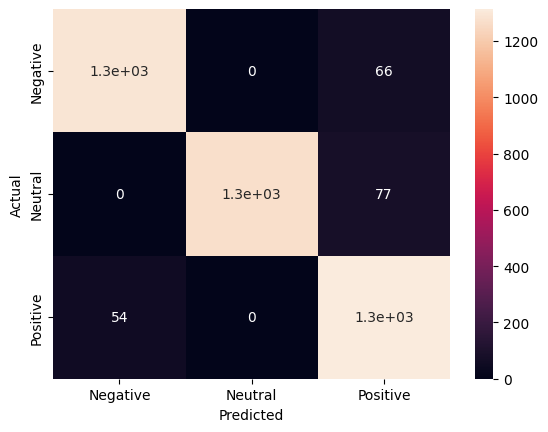

In [30]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
cm= confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [31]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

          -1       0.96      0.95      0.96      1357
           0       1.00      0.94      0.97      1344
           1       0.90      0.96      0.93      1367

    accuracy                           0.95      4068
   macro avg       0.95      0.95      0.95      4068
weighted avg       0.95      0.95      0.95      4068



In [32]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
y_test_bin = label_binarize(y_test, classes=[-1, 0, 1])
y_pred_bin = label_binarize(y_pred, classes=[-1, 0, 1])
auroc = roc_auc_score(y_test_bin, y_pred_bin, average="macro", multi_class="ovr")
print(f"AUROC: {auroc:.2f}")


AUROC: 0.96


In [33]:
auroc = roc_auc_score(y_test_bin, y_pred_bin, average="macro", multi_class="ovr")
print(f"AUROC: {auroc:.2f}")

AUROC: 0.96


In [34]:
import joblib

In [35]:
joblib.dump(pipe,'review_classifier_IITG.pkl')

['review_classifier_IITG.pkl']